In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import keras
from keras.layers import LSTM, Dense, Activation, RNN
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

data = sio.loadmat("Xtrain.mat")["Xtrain"]
print(data.shape)

Using TensorFlow backend.


(1000, 1)


In [2]:
# create a scaler and fit it on data
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)

data_normed = scaler.transform(data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


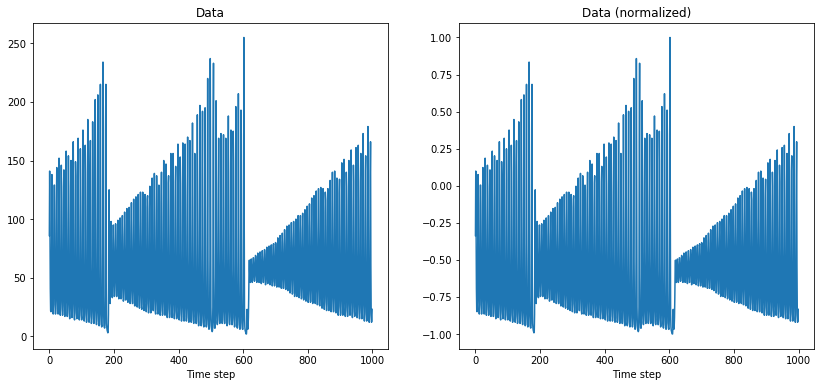

In [3]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(data)
plt.title("Data")
plt.xlabel("Time step")

plt.subplot(122)
plt.plot(data_normed)
plt.title("Data (normalized)")
plt.xlabel("Time step")
plt.show()

In [4]:
# def save_model(model):
#     model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
#     model.save_weights("model.h5")
#     print("Saved model")
    
    
def load_model():
#     with open('model.json', 'r') as f:
#         loaded_model_json = f.read()
#         loaded_model = model_from_json(loaded_model_json)
#         load_model.load_weights("model.h5")
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model")
    return loaded_model


In [12]:
inputsize = 200

def get_model():
    model = keras.Sequential()
    model.add(LSTM(16, return_sequences=True, input_shape=(trainX.shape[1], 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(8, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
    return model

# Create train and test data (model is trained on sequence and should predict the next timestep)
targetIndex = np.array(range(inputsize, len(data)))

# Compare normalized and not normalized data (data/data_normed)
inputdata = np.array([data_normed[ind-inputsize:ind] for ind in targetIndex])
target = data_normed[targetIndex]

print(f'inputdata Shape {inputdata.shape}')
print(f'target Shape {target.shape}')

# Split into train and test
splitInd = int(len(inputdata)*0.9)
trainX = inputdata[:splitInd]
trainY = target[:splitInd]
testX = inputdata[splitInd:]
testY = target[splitInd:]
print("trainX.shape", trainX.shape)
print("trainY.shape", trainY.shape)
print("testX.shape", testX.shape)
print("testY.shape", testY.shape)

# Create model
model = get_model()
# Train it
history = model.fit(trainX, trainY, epochs=50, validation_data=(testX, testY), verbose=2, shuffle=True)
# Save it
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model")



inputdata Shape (800, 200, 1)
target Shape (800, 1)
trainX.shape (720, 200, 1)
trainY.shape (720, 1)
testX.shape (80, 200, 1)
testY.shape (80, 1)
Train on 720 samples, validate on 80 samples
Epoch 1/50
 - 7s - loss: 0.3265 - acc: 0.0000e+00 - val_loss: 0.2429 - val_acc: 0.0000e+00
Epoch 2/50
 - 4s - loss: 0.1549 - acc: 0.0014 - val_loss: 0.1786 - val_acc: 0.0000e+00
Epoch 3/50


KeyboardInterrupt: 

pred.shape  (80, 1)


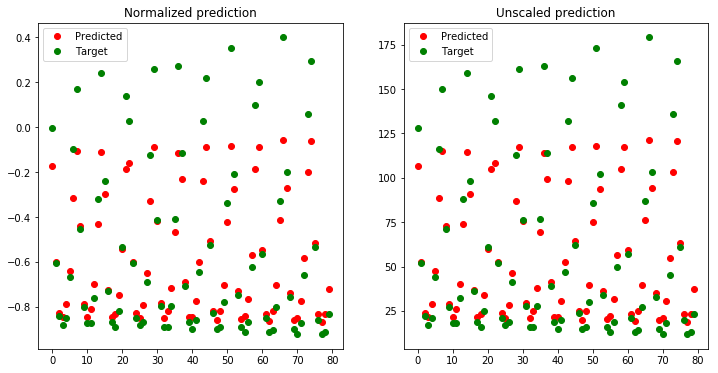

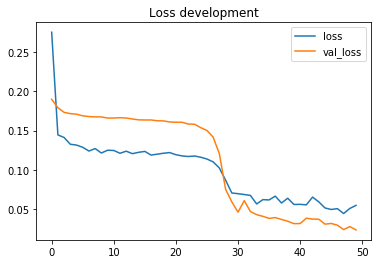

In [10]:
# model = load_model()

pred = model.predict(testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)
print("pred.shape ", pred.shape)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

plt.title('Loss development')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Predict a timeseries of 200 timesteps recursively

(720, 200, 1)


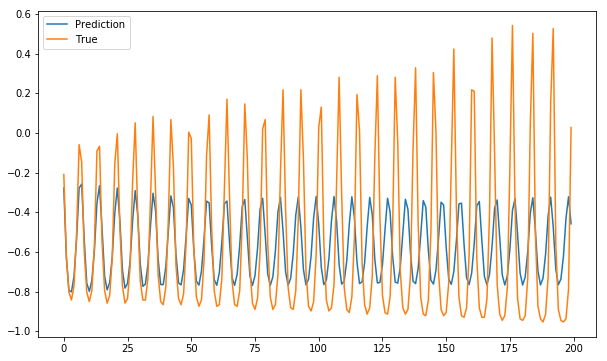

In [11]:
def forecast(model, inp, timesteps=200):
    for i in range(timesteps):
        # make forecast
        pred = model.predict(inp.reshape(1,len(inp),1))
#         print(pred)
        # add it and use it as new input
        inp = np.append(inp, pred)
        inp = inp[-inputsize:]
    return inp

print(trainX.shape)
i = 90
forecast_pred = forecast(model, trainX[i], 200)
true_forecast = trainX[i+200]
plt.figure(figsize=(10,6))
plt.plot(forecast_pred, label='Prediction')
plt.plot(true_forecast, label='True')
plt.legend()
plt.show()

## Try to implement K-Fold crossvalidation and save the n-best models to use as ensemble

In [ ]:
models = []
n_folds = 10
kf = KFold(n_splits=n_folds)
iteration = 1
for train_index, test_index in kf.split(inputdata, target):
    trainX, trainY = inputdata[train_index], target[train_index]
    testX, testY = inputdata[test_index], target[test_index]

    # Create model
    model = get_model()
    # Train it
    history = model.fit(trainX, trainY, epochs=50, validation_split=0.1, verbose=2)

    models.append(model)
    score = model.evaluate(testX, testY)[0]
    print(f'Iteration: {iteration} with score: {score}')
    iteration += 1

Iteration: 0
Train on 648 samples, validate on 72 samples
Epoch 1/50
648/648 [==============================] - 7s 11ms/step - loss: 0.2404 - acc: 0.0000e+00 - val_loss: 0.1756 - val_acc: 0.0000e+00
Epoch 2/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1556 - acc: 0.0031 - val_loss: 0.1738 - val_acc: 0.0000e+00
Epoch 3/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1403 - acc: 0.0015 - val_loss: 0.1714 - val_acc: 0.0000e+00
Epoch 4/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1429 - acc: 0.0015 - val_loss: 0.1712 - val_acc: 0.0000e+00
Epoch 5/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1398 - acc: 0.0031 - val_loss: 0.1702 - val_acc: 0.0000e+00
Epoch 6/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1386 - acc: 0.0015 - val_loss: 0.1697 - val_acc: 0.0000e+00
Epoch 7/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1363 - acc: 0.0015 - val_loss: 0.1692 - val_a

648/648 [==============================] - 4s 6ms/step - loss: 0.1265 - acc: 0.0000e+00 - val_loss: 0.1682 - val_acc: 0.0000e+00
Epoch 10/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1260 - acc: 0.0031 - val_loss: 0.1682 - val_acc: 0.0000e+00
Epoch 11/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1253 - acc: 0.0031 - val_loss: 0.1676 - val_acc: 0.0000e+00
Epoch 12/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1237 - acc: 0.0031 - val_loss: 0.1675 - val_acc: 0.0000e+00
Epoch 13/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1249 - acc: 0.0031 - val_loss: 0.1677 - val_acc: 0.0000e+00
Epoch 14/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1246 - acc: 0.0031 - val_loss: 0.1672 - val_acc: 0.0000e+00
Epoch 15/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1244 - acc: 0.0031 - val_loss: 0.1671 - val_acc: 0.0000e+00
Epoch 16/50
648/648 [============================

Epoch 18/50
648/648 [==============================] - 4s 6ms/step - loss: 0.1010 - acc: 0.0000e+00 - val_loss: 0.1336 - val_acc: 0.0000e+00
Epoch 19/50
648/648 [==============================] - 4s 6ms/step - loss: 0.0957 - acc: 0.0000e+00 - val_loss: 0.1176 - val_acc: 0.0000e+000s - loss: 0.0916 - acc: 0.0000e+
Epoch 20/50
648/648 [==============================] - 4s 6ms/step - loss: 0.0860 - acc: 0.0015 - val_loss: 0.0865 - val_acc: 0.0000e+00
Epoch 21/50
648/648 [==============================] - 4s 6ms/step - loss: 0.0706 - acc: 0.0031 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 22/50
648/648 [==============================] - 4s 6ms/step - loss: 0.0720 - acc: 0.0000e+00 - val_loss: 0.0508 - val_acc: 0.0000e+00
Epoch 23/50
648/648 [==============================] - 4s 6ms/step - loss: 0.0611 - acc: 0.0015 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 24/50
648/648 [==============================] - 4s 6ms/step - loss: 0.0659 - acc: 0.0000e+00 - val_loss: 0.0513 - val_acc: 0.0

In [ ]:
# Save models
def save_models(models):
    for i, m in enumerate(models):
        model_json = m.to_json()
        with open(f"model{i}.json", "w") as json_file:
            json_file.write(model_json)
            # serialize weights to HDF5
            model.save_weights(f"model{i}.h5")
    print("Saved model")

def ensemble_predictions(models, testX):
    # make predictions
    yhats = [model.predict(testX) for model in models]
    # median across ensemble members
    result = np.mean(yhats, axis=0)
    return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(models, n_models, testX, testy):
    # select a subset of members
    subset = models[:n_models]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return mean_squared_error(testy, yhat)
    

validationX, validationY = testX, testY
single_MSEs, ensemble_MSEs = [], []
for i in range(1, n_folds+1):
    ensemble_MSE = evaluate_n_members(models, i, validationX, validationY)
    # looks at accuracy right now (maybe bad?)
    single_MSE, _ = models[i-1].evaluate(validationX, validationY, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_MSE, ensemble_MSE))
    ensemble_MSEs.append(ensemble_MSE)
    single_MSEs.append(single_MSE)
# plot score vs number of ensemble members
print('MSE %.3f (%.3f)' % (np.mean(single_MSEs), np.std(single_MSEs)))
x_axis = [i for i in range(1, n_folds+1)]
plt.plot(x_axis, single_MSEs, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_MSEs, marker='o')
plt.show()

In [ ]:
pred = ensemble_predictions(models[:6], testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

print("MSE: ", mean_squared_error(testY_unscaled, pred_unscaled))